In [3]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [ ]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)

df = df[~df["written"]]
print(f"#Samples: {len(df)}")

#Samples: 9705


In [5]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

In [6]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()
y = lb.fit_transform(df["block"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X_train, y)

reduced = pls.transform(X)

print(f"PLS r-squared {pls.score(X_test, np.eye(len(lb.classes_))[y_test]):.3f}")


#Classes 6
PLS r-squared 0.116


## Plotting Results

In [8]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict, ax):
  ax.set_title("Two Dimensional Projection of Political Groups")

  grt = np.abs(reduced_embeddings).max() * 1.1

  ax.set_xlim(-grt, grt)
  ax.set_ylim(-grt, grt)

  scale = grt * 2


  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        ax.text(party_embeddings[i,0] - scale * 0.01, party_embeddings[i,1]+ scale * 0.015, f"{year}",
                  fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                  color='white',
                  )

  ax.axhline(0, linestyle="--")
  ax.axvline(0, linestyle="--")
  ax.grid()
  ax.legend(loc="upper left")
  return ax

In [9]:
def plot_pca_axis_development(axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict, ax: plt.Axes,
                              top_k: int = 3):

    ax.set_title(f"Development of parties over the years accross reduced-axis {axis}")

    for party in aggregated[target_var].unique():
        party_mask = aggregated[target_var] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced_embeddings[party_mask]
        ax.plot(years,  party_embeddings[:, axis], marker='o', color=color_map[party])

    
    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()
    # ax.legend(loc="lower left")


In [10]:
def display_results(model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    
    fig = plt.figure(layout="constrained", figsize=(18, 8))

    gs0 = fig.add_gridspec(1, 2)

    gs1 = gs0[1].subgridspec(2, 1)

    ax1 = fig.add_subplot(gs0[0])
    ax2 = fig.add_subplot(gs1[0])
    ax3 = fig.add_subplot(gs1[1], sharex=ax2)

    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map, ax1)
    plot_pca_axis_development(0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map, ax2)
    plot_pca_axis_development(1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map, ax3)


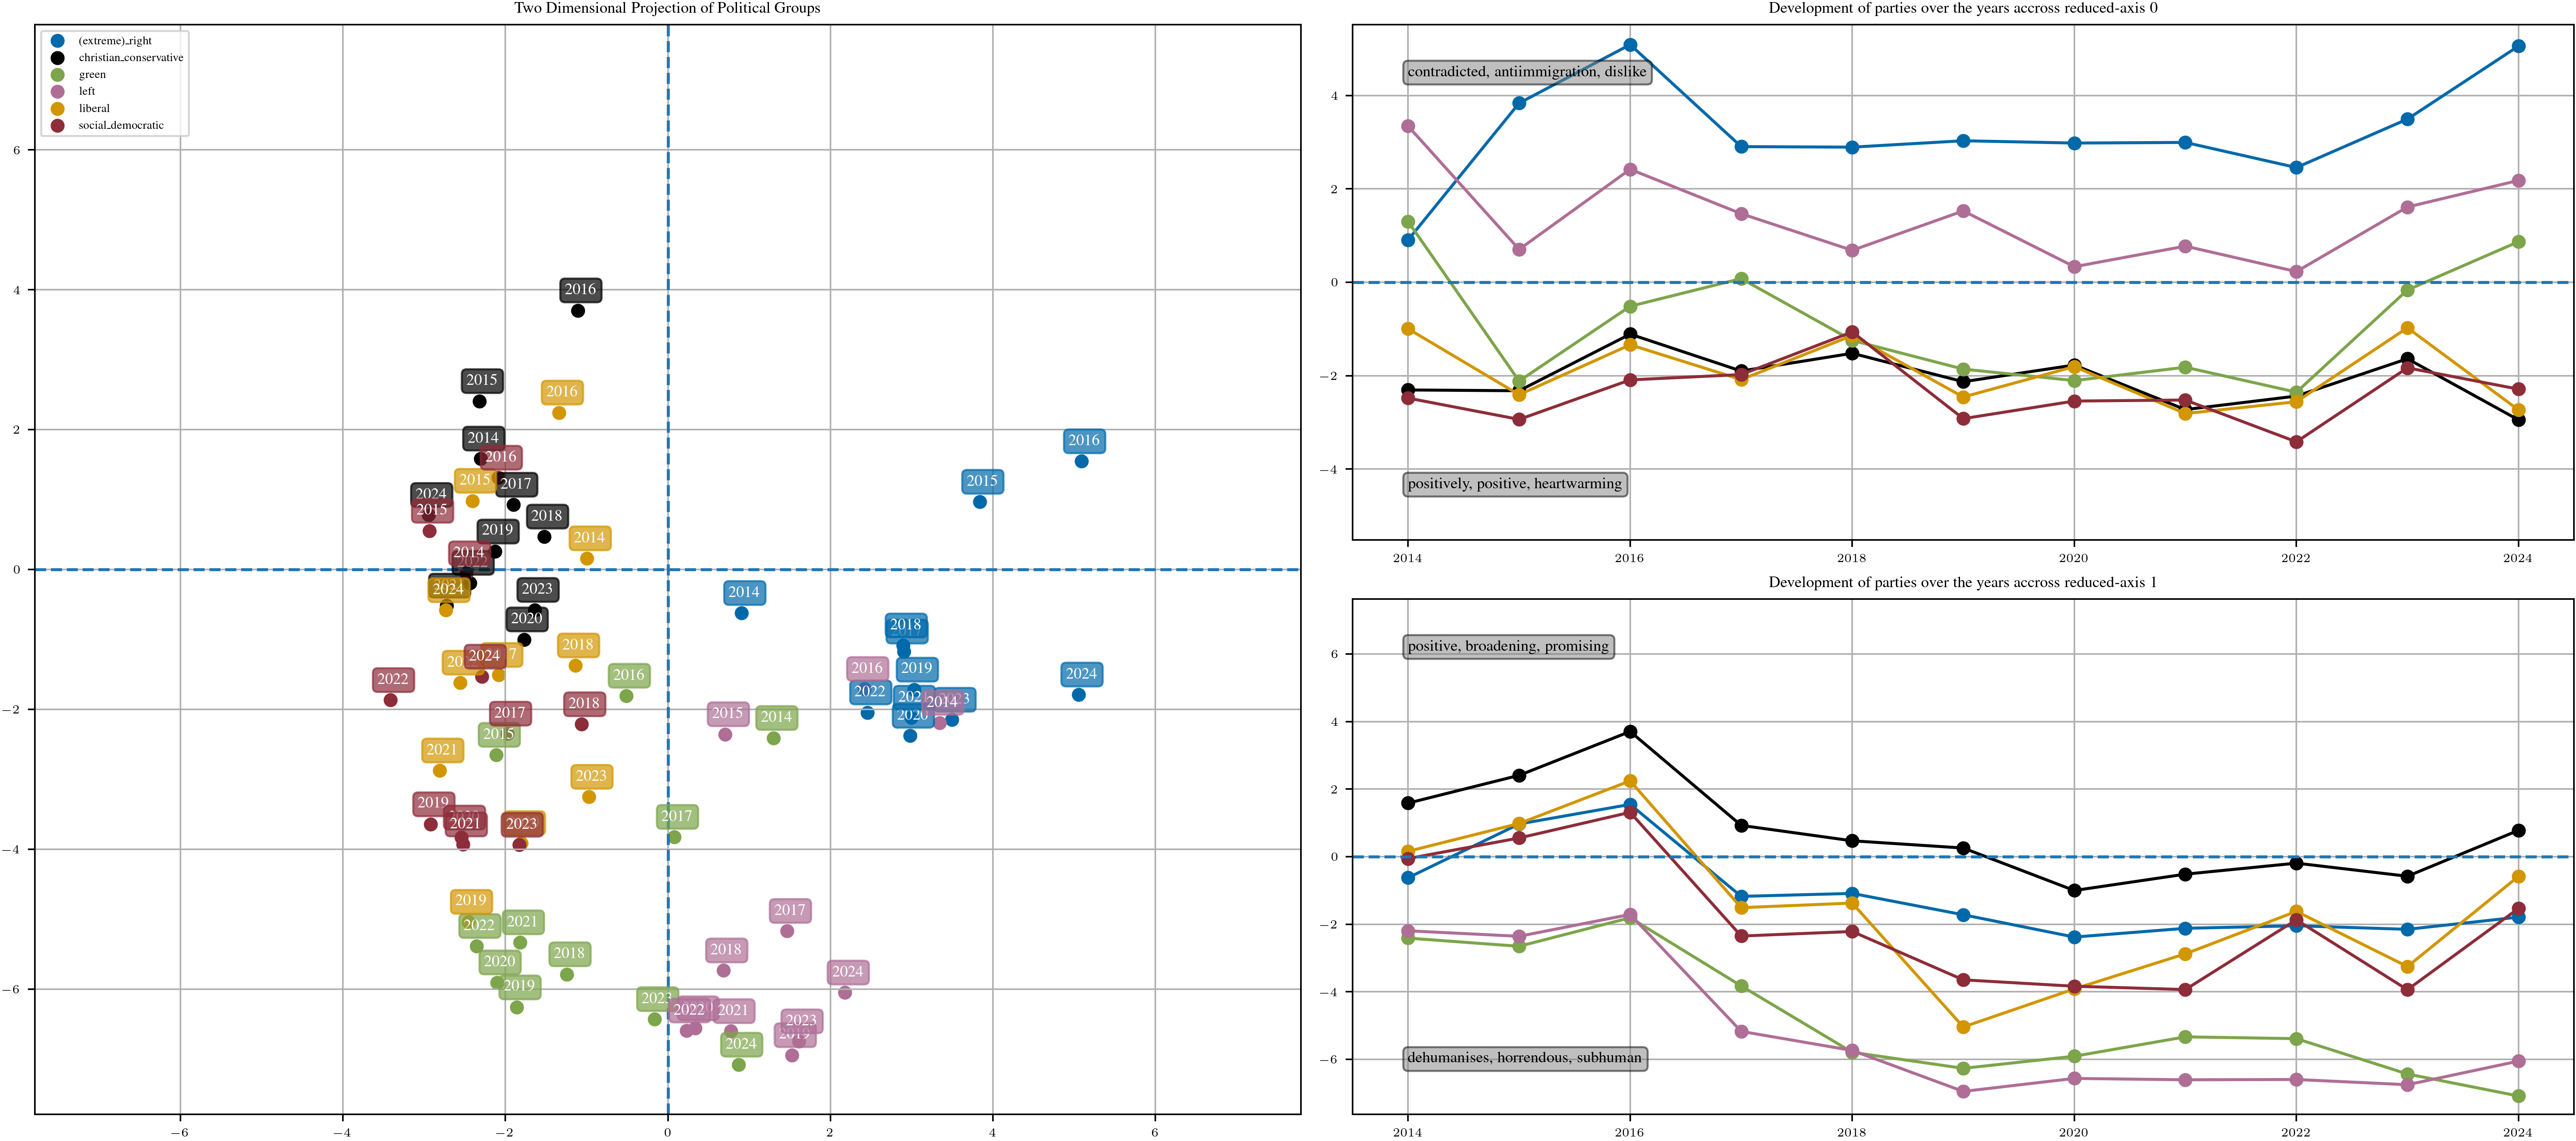

In [11]:
display_results(pls, [0, 1], aggregated, vocab_df, 
                pls.transform(np.stack(aggregated[EMBEDDING_MODEL])), "block", COLOR_MAPS['block'])

In [10]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))
normalized = reduced 
#/ np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)

In [11]:
def get_top_k_extreme_examples(df: pd.DataFrame, embeddings: np.array, top_k=10):
    sorted_0 = embeddings[:, 0].argsort()
    sorted_1 = embeddings[:, 1].argsort()
    return df.iloc[sorted_0[:top_k]], df.iloc[sorted_0[-top_k:]], df.iloc[sorted_1[:top_k]], df.iloc[sorted_1[-top_k:]]

In [13]:
df.iloc[6912]['translatedText']

'I voted against this report, because it gives an inappropriate role to migrants.'

In [ ]:
import textwrap


left_mask = df['block'] == '(extreme)_right'
neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[left_mask], normalized[left_mask])

In [71]:
for row in neg_1.iloc:
    print(textwrap.fill(row['translatedText']))
    print("=" * 200)

Madam President, the Moria camp is indeed a tragedy, but it is a
tragedy that it even existed. It was burned by those who were inside,
because they wanted to accelerate their illegal entry into a continent
that cannot accommodate all other continents, no matter how many
people we have here representing, with that apparent moral
superiority, those who want to welcome everyone who wishes to come.
Because there is no room for them. And let's see if we show a little
respect for Europeans. Let's see if we respect the Greeks, who are
suffering because their habitat in Lesbos and so many other islands
has been destroyed. Why don't we address the root causes? Why don't we
look at Turkey, which has been manipulating these refugees, these
illegal immigrants who are gathering there, none of whom have the
right to asylum, who should have been deported and sent to their
countries of origin long ago, but who are being used by Turkey? Why
did everyone here condemn Turkey yesterday, and now they are i

In [72]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [75]:
axis_labels_0[1]

[('dislike', np.float64(16.59002774816587)),
 ('contradicted', np.float64(16.65052587957544)),
 ('haters', np.float64(16.76100165292463)),
 ('antipathy', np.float64(16.81529173859419)),
 ('antiimmigrants', np.float64(16.821122052691116)),
 ('nonsense', np.float64(16.82908249101192)),
 ('unpalatable', np.float64(16.838662663034192)),
 ('antiimmigration', np.float64(16.853263856596843)),
 ('denounces', np.float64(16.90338182059873)),
 ('disapproval', np.float64(17.015671532434794)),
 ('ridiculous', np.float64(17.13823664148516)),
 ('disproven', np.float64(17.396143786077772)),
 ('disapprove', np.float64(17.48945637820371)),
 ('pejorative', np.float64(17.50769091732936)),
 ('dislikes', np.float64(17.549047163096038)),
 ('perverse', np.float64(17.631384938659533)),
 ('negate', np.float64(18.111295884635297)),
 ('aversion', np.float64(18.470221841137246)),
 ('negatively', np.float64(19.515675212338543)),
 ('negative', np.float64(19.679150134685766))]

In [78]:
words_neg_0, words_pos_0 = [[item[0] for item in axis_label] for axis_label in axis_labels_0]
words_neg_1, words_pos_1 = [[item[0] for item in axis_label] for axis_label in axis_labels_1]

In [166]:
examples = []

for block in df['block'].unique():
    block_mask = df['block'] == block
    neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[block_mask], normalized[block_mask], top_k=3)

    examples.extend([{"Axis": "First", 
    "Direction": "Positive (Right)",
    "Labels": ", ".join(words_pos_0),
    "Block": block,
    **{ f"Example: {idx}":  textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(pos_0.iloc)}},


    {"Axis": "First", 
    "Direction": "Negative (Left)",
    "Labels": ", ".join(words_neg_0),
    "Block": block,
    **{ f"Example: {idx}":textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(neg_0.iloc)}},


    {"Axis": "Second", 
    "Direction": "Positive (Up)",
    "Labels": ", ".join(words_pos_1),
    "Block": block,
    **{ f"Example: {idx}":  textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(pos_1.iloc)}},


    {"Axis": "Second", 
    "Direction": "Negative (Down)",
    "Labels": ", ".join(words_neg_1),
    "Block": block,
    **{ f"Example: {idx}": textwrap.fill(row['translatedText'], width=100) for idx, row in enumerate(neg_1.iloc)}}])



In [171]:
examples_df = pd.DataFrame(examples)

In [172]:
examples_df = examples_df.sort_values(by=['Axis', 'Direction', 'Labels', 'Block'])

In [173]:
examples_df = examples_df.set_index([ 'Axis', 'Direction', 'Labels', 'Block' ])


In [174]:
from IPython.display import display, HTML

display(HTML(examples_df.to_html()))

In [83]:
pos_1['block']

140770    christian_conservative
140819    christian_conservative
140664         social_democratic
140708    christian_conservative
140667    christian_conservative
140872    christian_conservative
140804         social_democratic
140823    christian_conservative
202688           (extreme)_right
140762    christian_conservative
Name: block, dtype: object

In [17]:
X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()

# create one-hot encodding to use PLS for classification PLS-DA

y_block = lb.fit_transform(df["block"])
y_block = np.eye(len(lb.classes_))[y_block]
y_year = lb.fit_transform(df["year"])
y_year = np.eye(len(lb.classes_))[y_year] 

y = np.concat([y_block, y_year], axis=1)


pls = PLSRegression(n_components=2)
pls.fit(X, y)

reduced = pls.transform(X)

# PLS + Clustering
With PLS and our vocab embeddings we can try to find out which 

In [18]:
len(df['party'].unique())

8

First thing we want to do is find num of clusters who can separate our data the most. For this we can use silhouette coefficient
nearest_other_cluster_dist - intra_cluster_dist / max_of_the_two

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm


silhouette_scores = {}

for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

    kmeans = KMeans(n_clusters=num_clusters)
    predicted_clusters = kmeans.fit_predict(X)

    silhouette_scores[num_clusters] = silhouette_score(X, predicted_clusters)


100%|██████████| 81/81 [03:05<00:00,  2.30s/it]


In [31]:
max(silhouette_scores.items(), key=lambda item: item[1])

(72, 0.03850667551159859)

Near 0 meaning clusters are overlaping, not as easily separable as we'd have liked

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# X = np.stack(df[EMBEDDING_MODEL])
# results = {}

# for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

#     kmeans = KMeans(n_clusters=num_clusters)
#     predicted_clusters = kmeans.fit_predict(X)

#     pls = PLSRegression(n_components=2)

#     y = np.eye(num_clusters)[predicted_clusters]

#     X_train, X_test, y_train, y_test = train_test_split(X, y)

#     pls.fit(X_train, y_train)

#     y_pred = pls.predict(X_test).argmax(axis=1)
#     y_test = y_test.argmax(axis=1)

    
#     results[num_clusters] = f1_score(y_test, y_pred, average="micro")  # classes are getting bigger as n_clusters increases so we want to make it n_class agnostic by measuring micro labels

100%|██████████| 81/81 [01:49<00:00,  1.35s/it]


In [38]:
kmeans = KMeans(n_clusters=72)
predicted_clusters = kmeans.fit_predict(X)

In [39]:
df.groupby(predicted_clusters)['block'].value_counts()

    block                 
0   (extreme)_right           61
    christian_conservative     4
    social_democratic          2
    green                      1
1   christian_conservative    73
                              ..
71  christian_conservative    38
    social_democratic         36
    green                     16
    left                      13
    liberal                   12
Name: count, Length: 417, dtype: int64

In [41]:
pls = PLSRegression(n_components=2)
y = np.eye(num_clusters)[predicted_clusters]
pls.fit(X, y)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


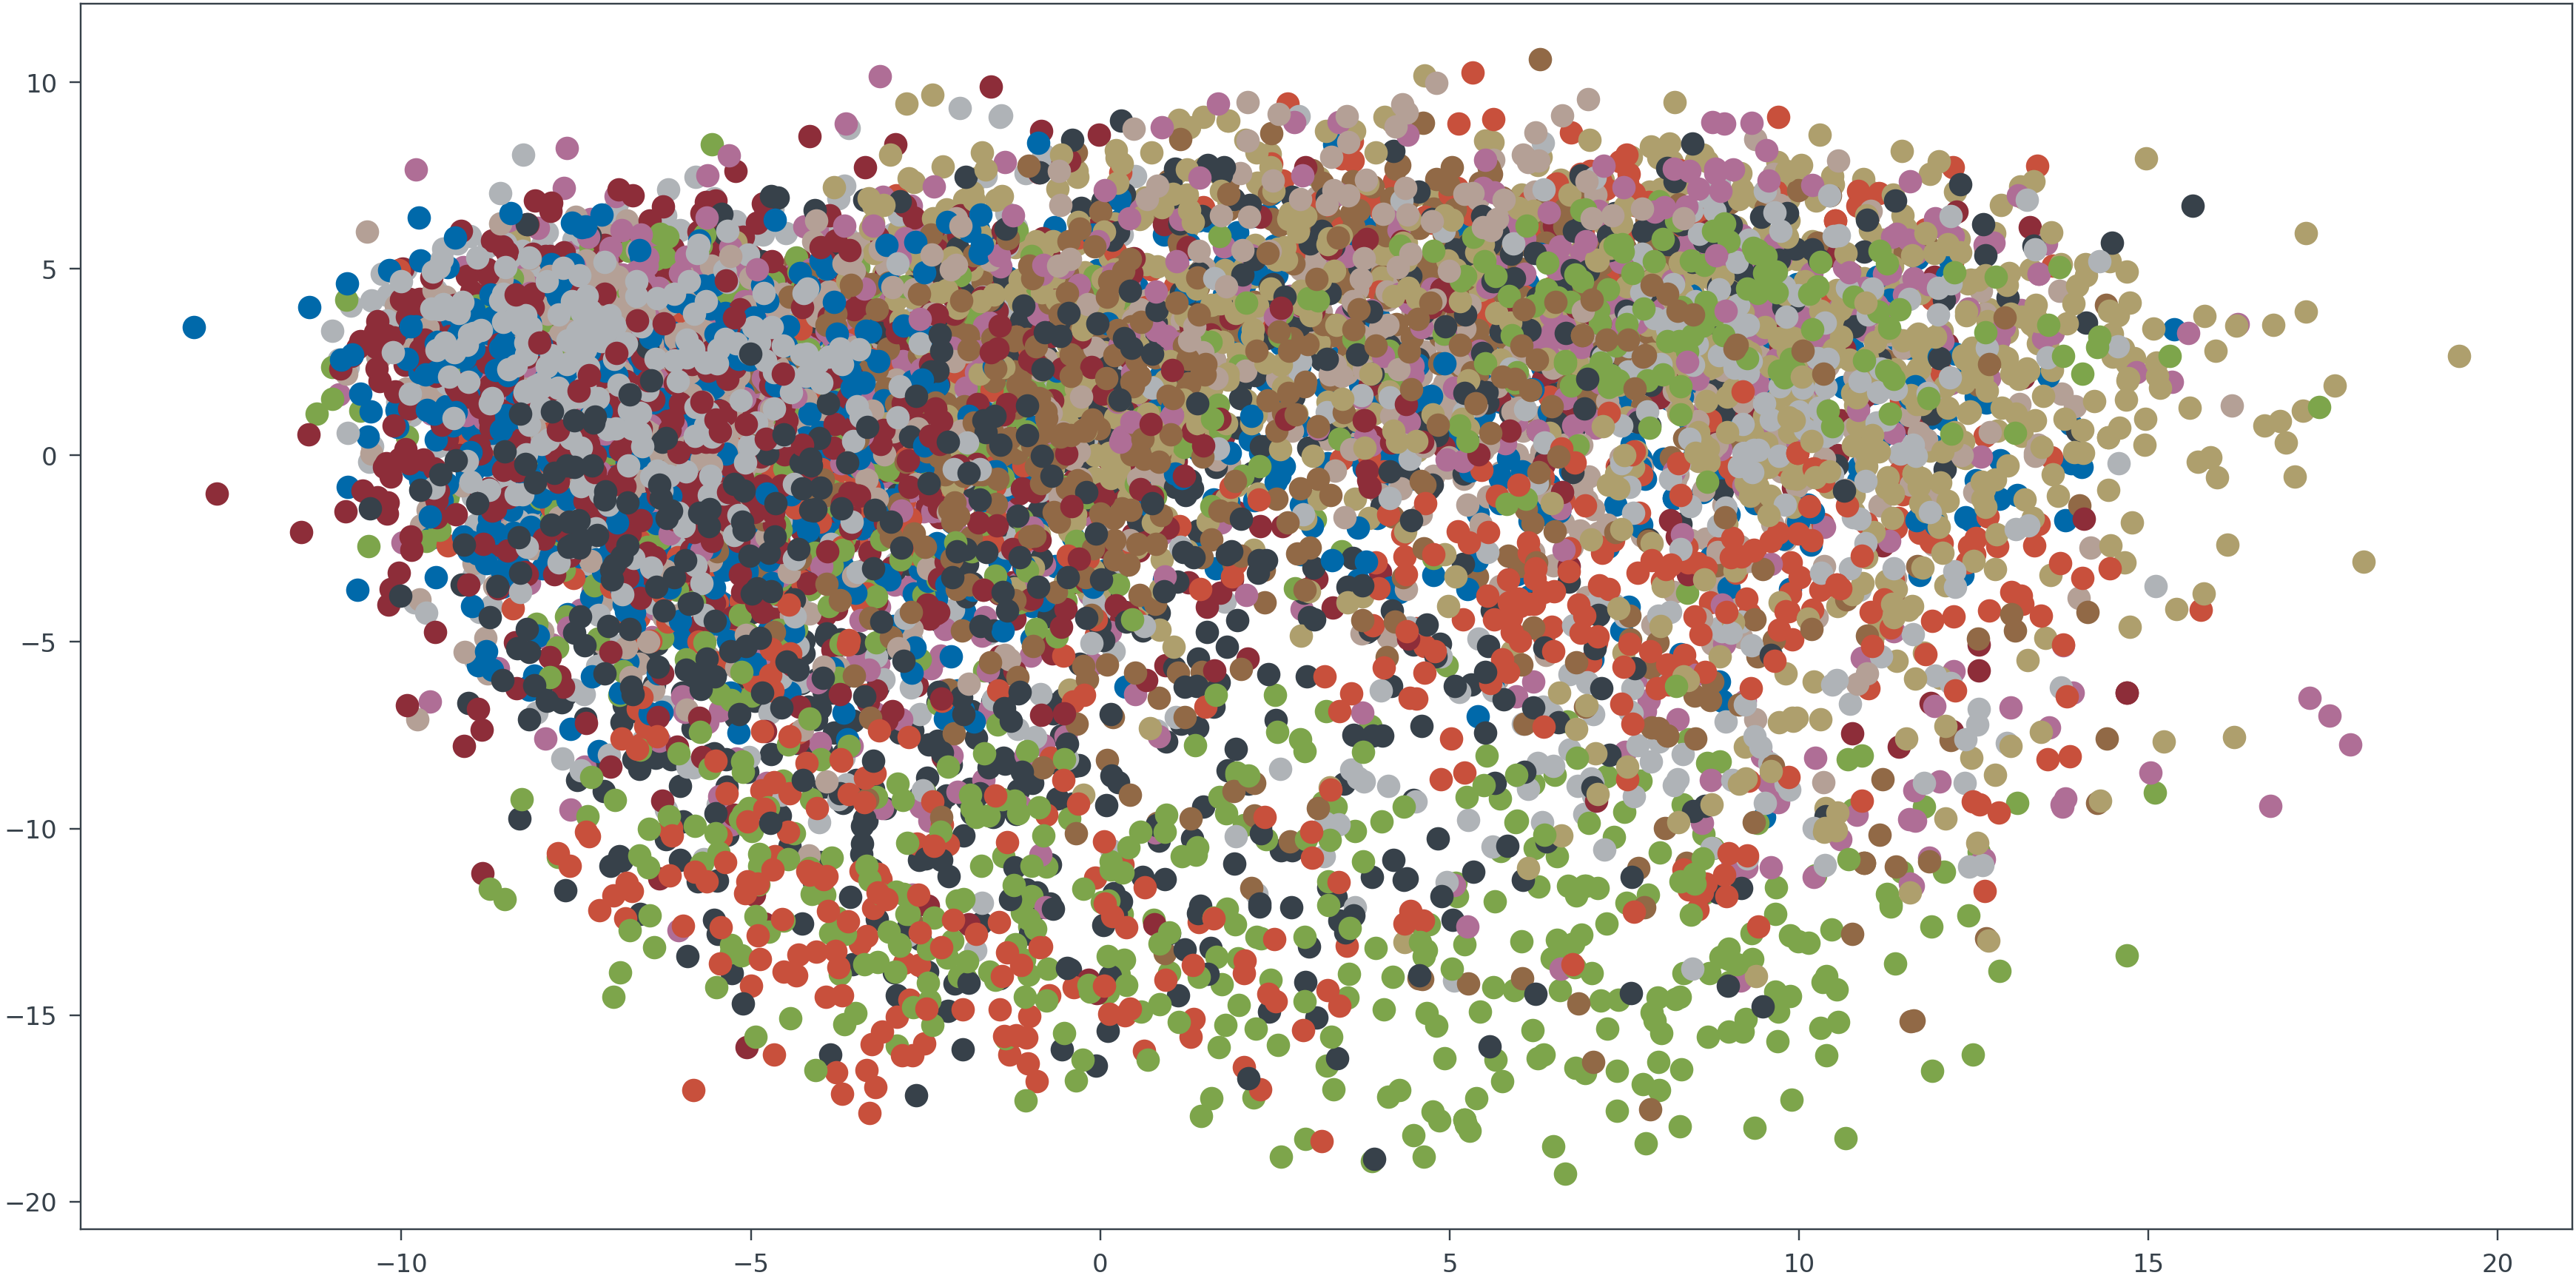

In [42]:
reduced = pls.transform(X)

fig, ax = plt.subplots(figsize=(10, 5))

for cluster_id in range(72):
    mask = predicted_clusters == cluster_id
    ax.scatter(reduced[mask, 0], reduced[mask, 1])

In [43]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [44]:
display_axis_semantics([axis_labels_0, axis_labels_1])